In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [2]:


# Paths to the DTM files
dtm_2018_path = "national_lidar_programme_dsm-2018-1-TQ07nw/DSM_TQ0075_P_10752_20180118_20180118.tif"
dtm_2023_path = "national_lidar_programme_dsm-2023-1-TQ07nw/DSM_TQ0075_P_12757_20230109_20230315.tif"

# Open the DTM files
with rasterio.open(dtm_2018_path) as src_2018, rasterio.open(dtm_2023_path) as src_2023:
    # Read the elevation data as numpy arrays
    dtm_2018 = src_2018.read(1).astype(np.float32)  # Ensure float32 to avoid overflow
    dtm_2023 = src_2023.read(1).astype(np.float32)

    # Get metadata (e.g., resolution, CRS, transform)
    profile = src_2018.profile

In [3]:
# Calculate the difference (2023 - 2018)
difference = dtm_2023 - dtm_2018

# Mask out NoData values (if any)
nodata_value = profile['nodata']
if nodata_value is not None:
    difference[(dtm_2018 == nodata_value) | (dtm_2023 == nodata_value)] = np.nan

# Replace Inf values with NaN to avoid propagation
difference[np.isinf(difference)] = np.nan

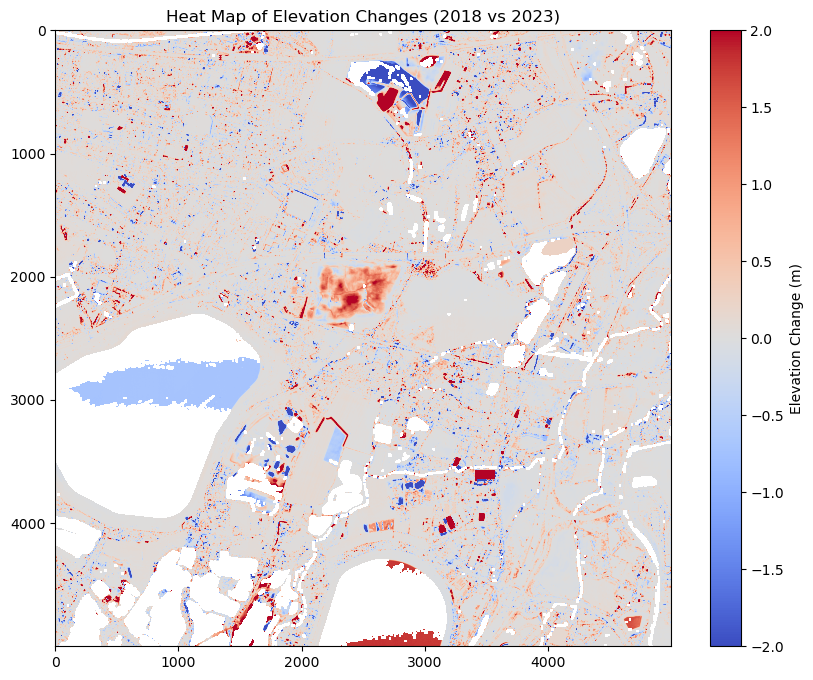

In [4]:


# Plot the heat map
plt.figure(figsize=(10, 8))
plt.imshow(difference, cmap='coolwarm', vmin=-2, vmax=2)  # Adjust vmin/vmax for better visualization
plt.colorbar(label="Elevation Change (m)")
plt.title("Heat Map of Elevation Changes (2018 vs 2023)")
plt.savefig("Elevation Change Heatmap", dpi=300, bbox_inches='tight')  # Save the figure
plt.show()

In [5]:


# Extract pixel resolution (assuming square pixels)
transform = profile['transform']
pixel_area = transform[0] * -transform[4]  # Pixel width * height

# Calculate total volume (in cubic meters)
# Use np.nansum to ignore NaN values during summation
volume_raise = np.nansum(np.where(difference > 0, difference, 0)) * pixel_area
volume_cut = np.nansum(np.where(difference < 0, difference, 0)) * pixel_area

print(f"Total Volume of Landraise (Fill): {volume_raise:.2f} m³")
print(f"Total Volume of Cut: {volume_cut:.2f} m³")

Total Volume of Landraise (Fill): 5252466.50 m³
Total Volume of Cut: -3889347.75 m³


In [6]:


# Save the difference raster
profile.update(dtype=rasterio.float32, nodata=np.nan)
output_path = "difference_2018_2023.tif"
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(difference.astype(rasterio.float32), 1)